In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline
import os

In [2]:
# Let's make a metric that constructs a template image at each HEALpix given some simple rules


In [3]:
class BuildTemplateMetric(maf.BaseMetric):
    """
    """
    def __init__(self, n_needed=3, n_max=6, mjd_col="observationStartMJD", seeing_col="seeingFwhmGeom",
        metric_name="template", seeing_limit=0.9, nights_back=730, night=None, 
                 night_col="night", m5_col="fiveSigmaDepth", **kwargs):
        self.n_needed = n_needed
        self.n_max = n_max
        self.nights_back = nights_back
        cols = [mjd_col, seeing_col, night_col, m5_col]
        self.night = night
        self.night_col=night_col
        self.m5_col = m5_col
        self.seeing_limit = seeing_limit
        super().__init__(
            col=cols, metric_name=metric_name, units="N"
        )
        self.mjd_col = mjd_col
        self.seeing_col = seeing_col
        
    def run(self, data_slice, slice_point=None):
        data_slice.sort(order=self.mjd_col)
        if self.night is None:
            night = np.max(data_slice[self.night_col])
        else:
            night = self.night
        
        recent_enough = data_slice[self.night_col] > (night-self.nights_back)
        seeing_enough = data_slice[self.seeing_col] < self.seeing_limit
        # could add a 
        
        result = {}
        if np.size(data_slice[recent_enough & seeing_enough]) >= self.n_needed:
            result["n"] = np.size(data_slice[recent_enough & seeing_enough])
            result["median seeing"] = np.median(data_slice[self.seeing_col][recent_enough & seeing_enough])
            result["coadd_m5"] = 1.25 * np.log10(np.sum(10.0 ** (0.8 * data_slice[self.m5_col][recent_enough & seeing_enough])))
        else:
            result = self.badval
        
        return result
    
    def reduce_n(self, data):
        return data["n"]
    def reduce_median_seeing(self, data):
        return data["median seeing"]
    def reduce_depth(self, data):
        return data["coadd_m5"]


Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/plots/plot_handler.py:587: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn(


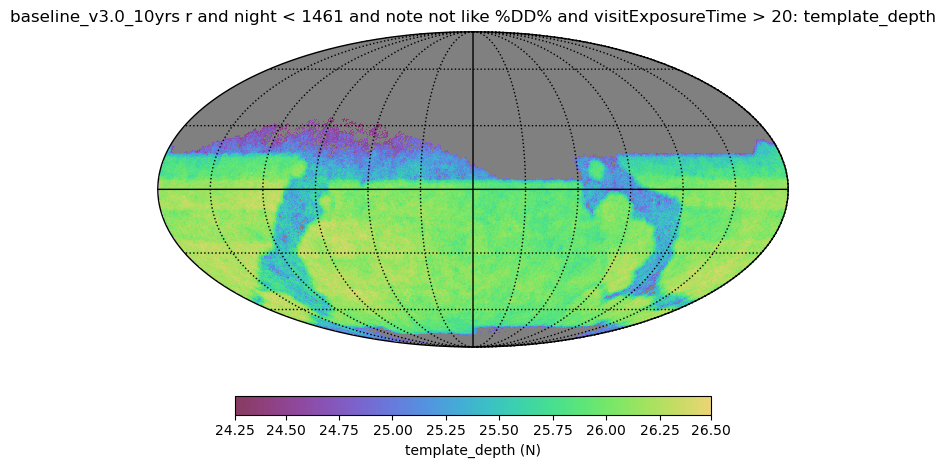

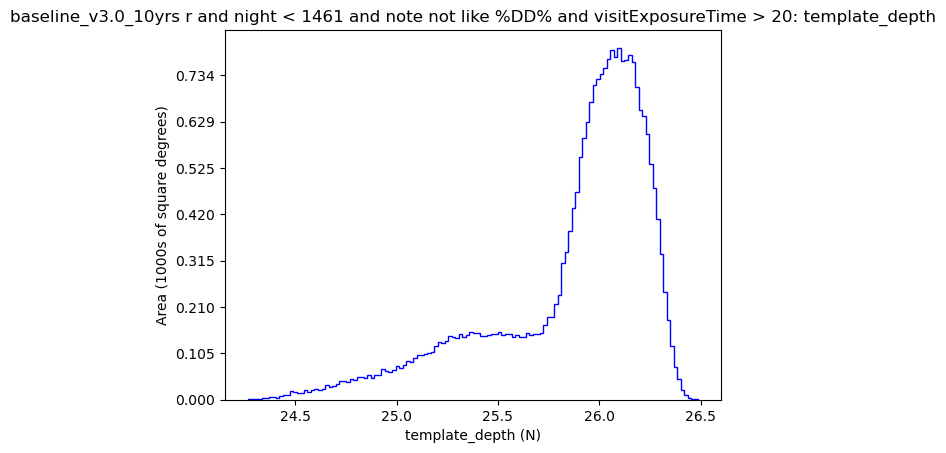

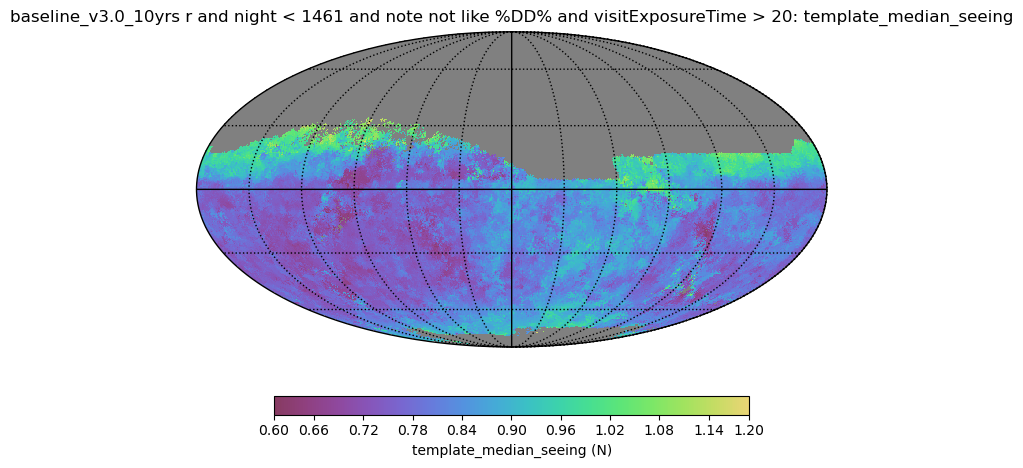

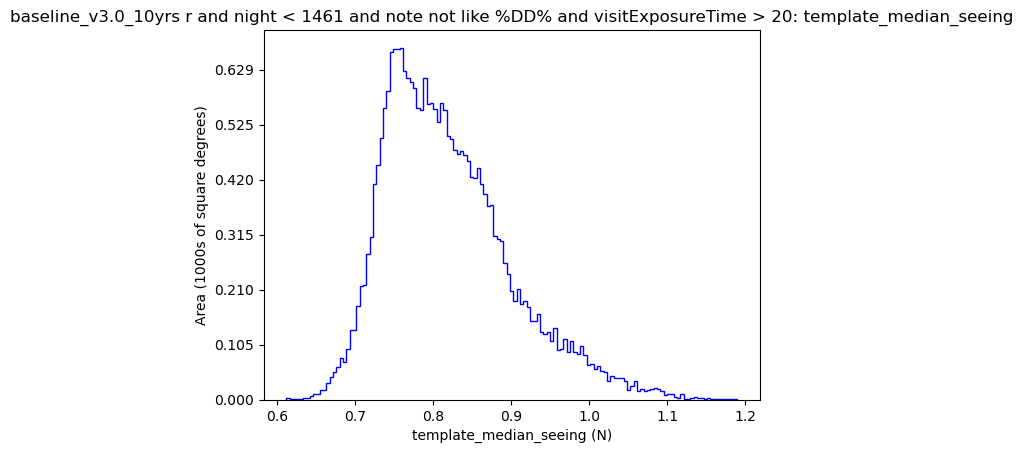

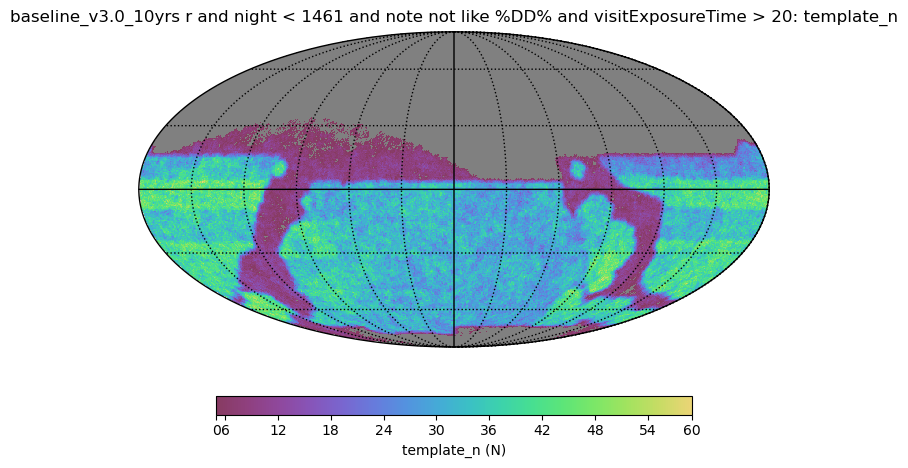

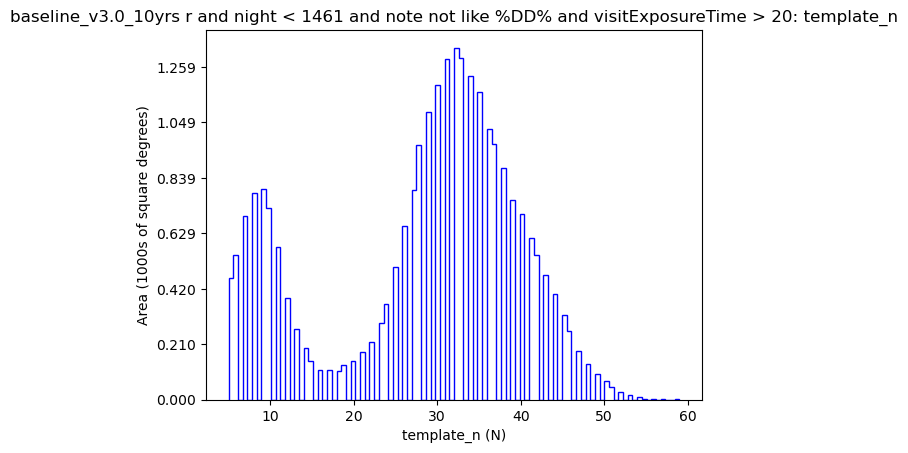

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/plots/plot_handler.py:587: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn(
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/plots/plot_handler.py:587: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn(


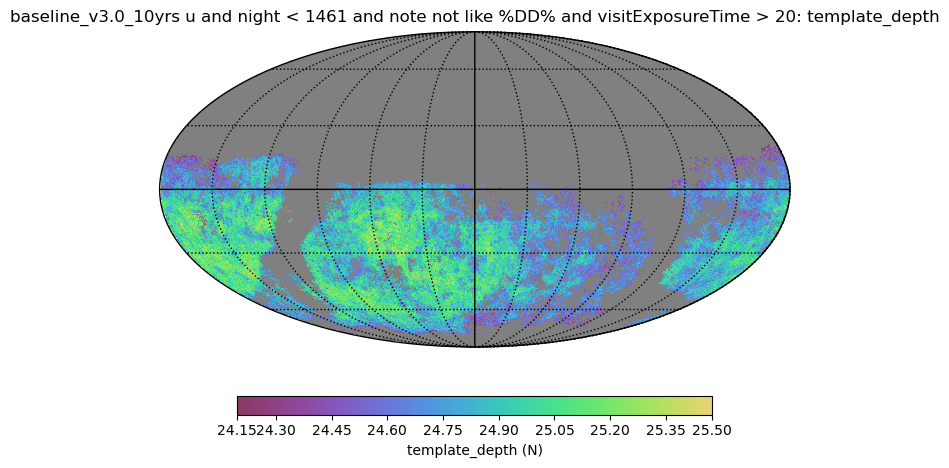

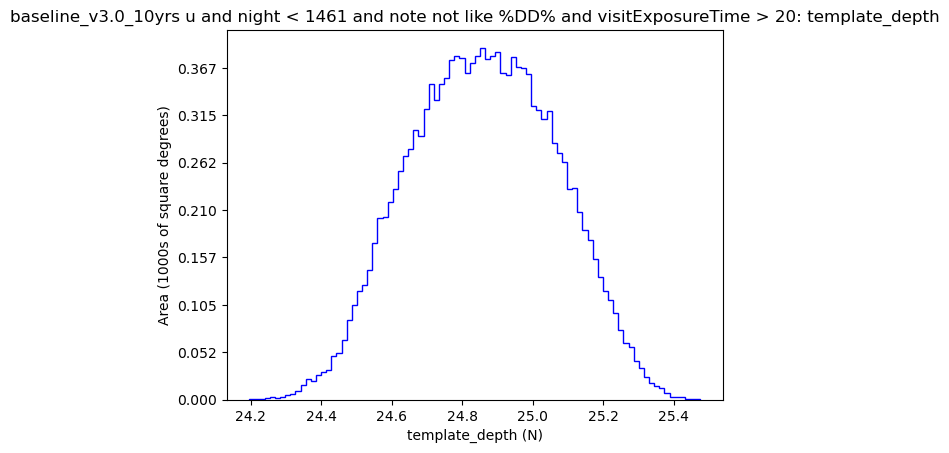

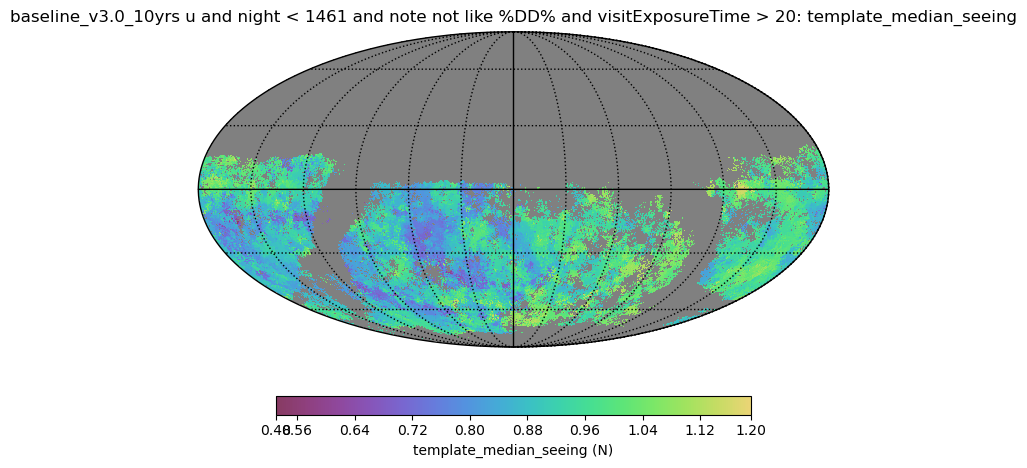

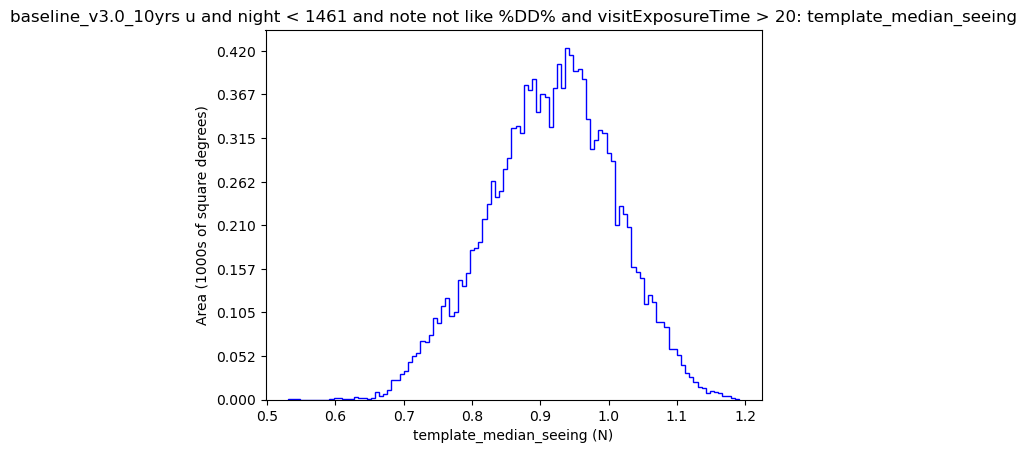

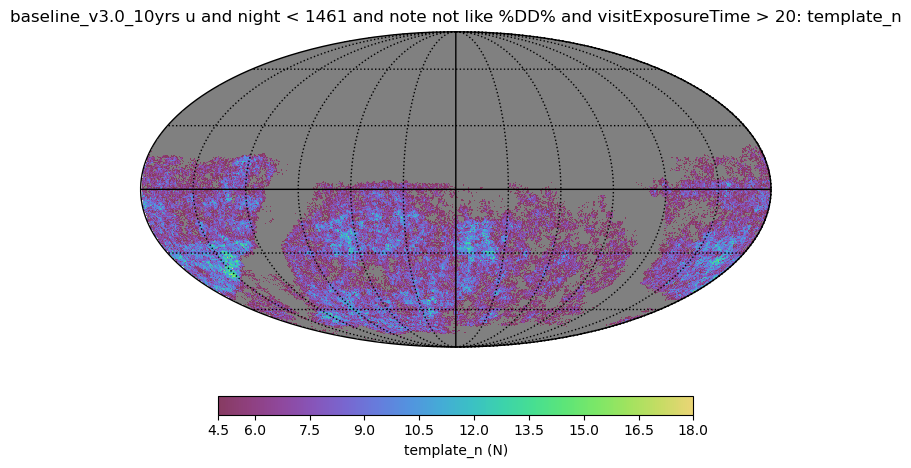

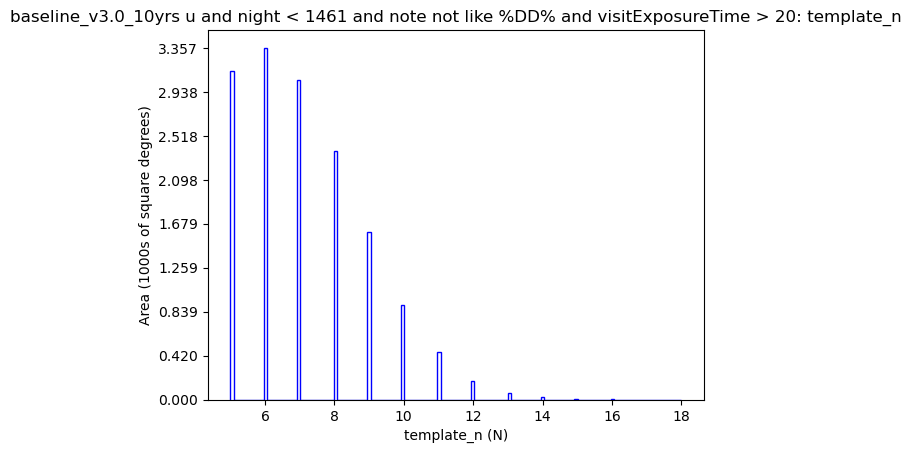

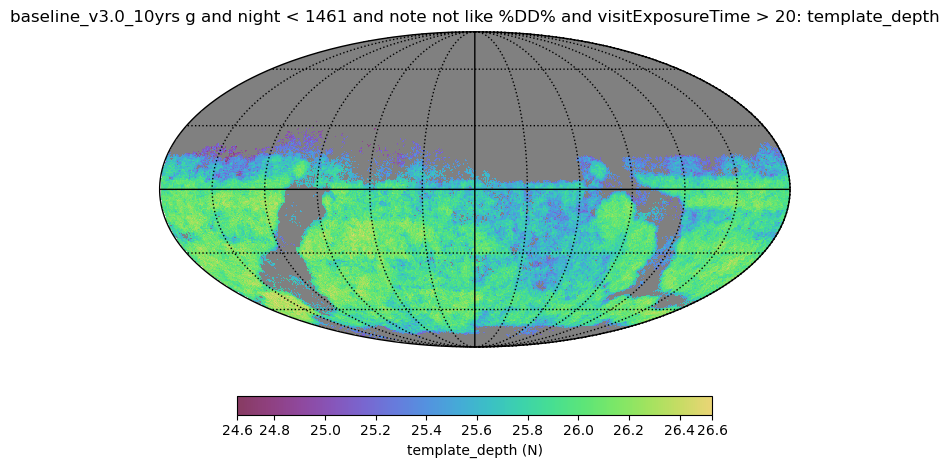

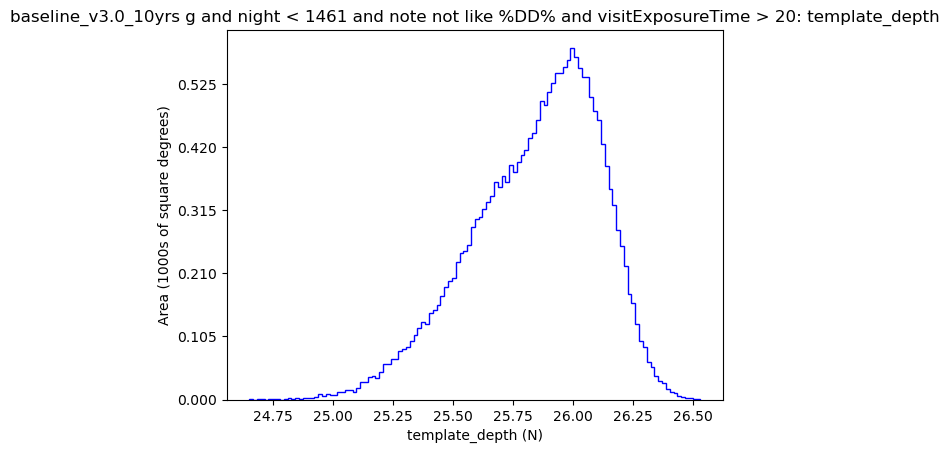

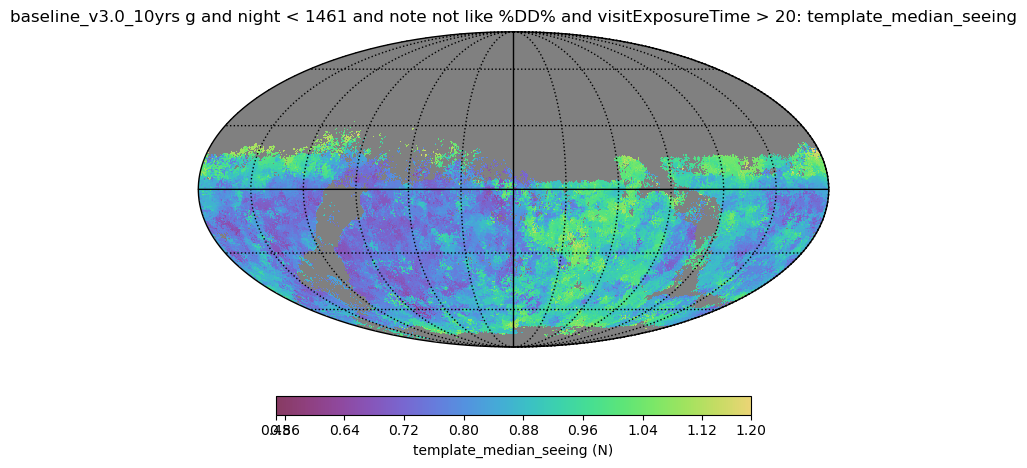

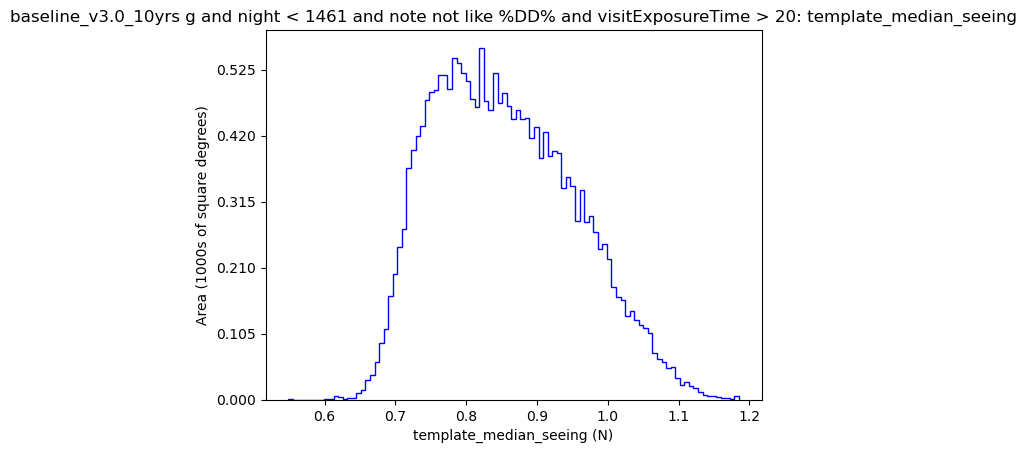

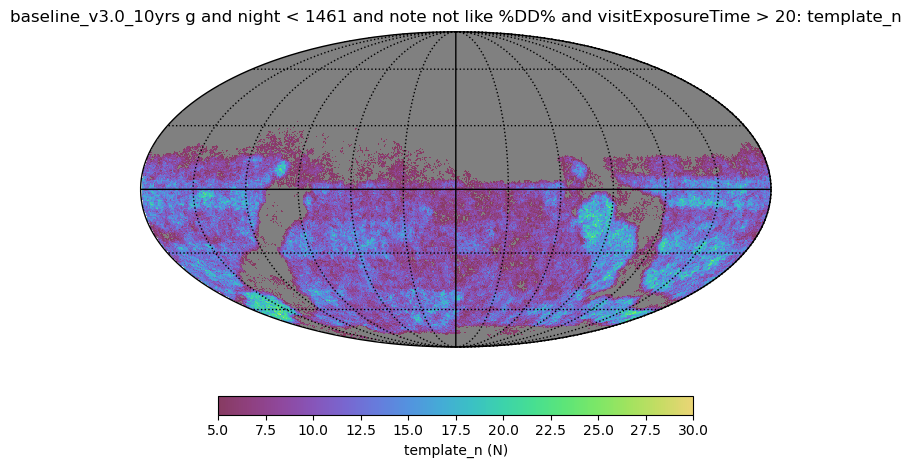

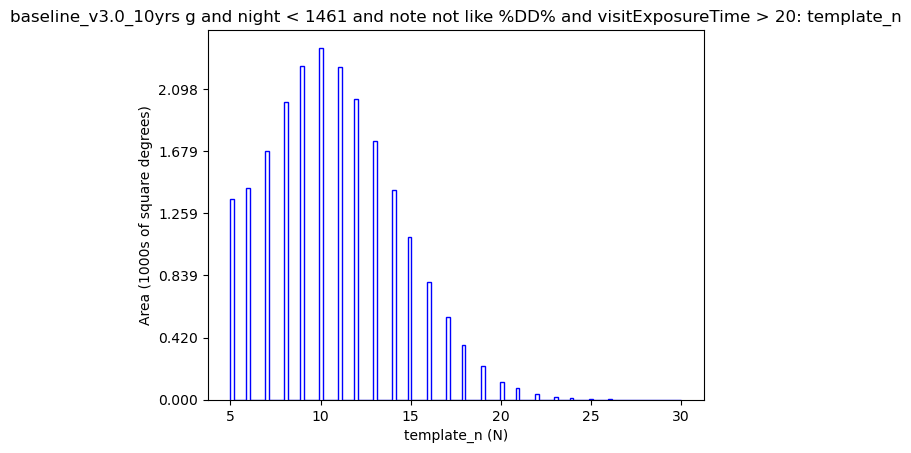

In [21]:
baseline = get_baseline()
run_name = os.path.basename(baseline).replace('.db', '')
bundle_list = []

night = 365.25*4

sqls = []
sqls.append('filter="u" and night < %i and note not like "%%DD%%" and visitExposureTime > 20' % night)
sqls.append('filter="g" and night < %i and note not like "%%DD%%" and visitExposureTime > 20' % night)
sqls.append('filter="r" and night < %i and note not like "%%DD%%" and visitExposureTime > 20' % night)

for sql in sqls:
    metric = BuildTemplateMetric(night=night, seeing_limit=1.2, n_needed=5, nights_back=365*2)
    slicer = maf.HealpixSlicer()
    bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=run_name))
    bd = maf.make_bundles_dict_from_list(bundle_list)


bg = maf.MetricBundleGroup(bd, baseline, out_dir='temp',results_db=None)
bg.run_all()
bg.plot_all(closefigs=False)